# Weight Decay Regularization

This notebook explores weight decay regularization in the form of a two-layer MLP being
trained on the MNIST dataset. Both train and test error are evaluated in the context of
no regularization, L2 regularization, and L1 regularization.

In [1]:
from nets import *

test_mnist = get_mnist(train=True)

full_model = MnistMLP(rate=0.01)

In [2]:
print(full_model)

MnistMLP(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=392, bias=True)
    (3): ReLU()
    (4): Linear(in_features=392, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
  (loss): NLLLoss()
)


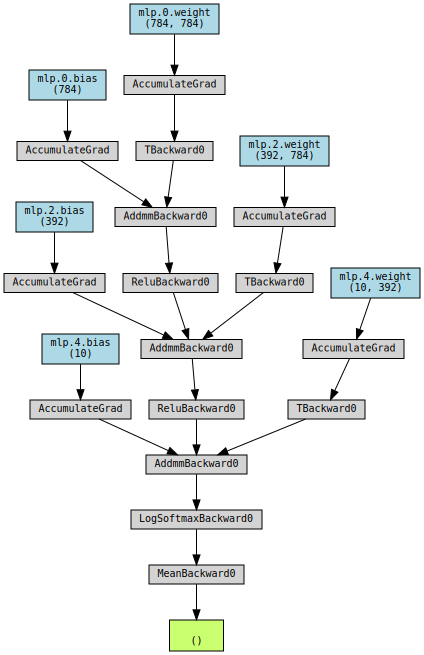

In [3]:
full_model.draw_network()